In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## 高斯混合模型

如果数据分离性好，那么用kmeans是很容易分的 

In [5]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples = 400, centers = 4,
                      cluster_std=0.6, random_state=0)
X = X[:,::-1]

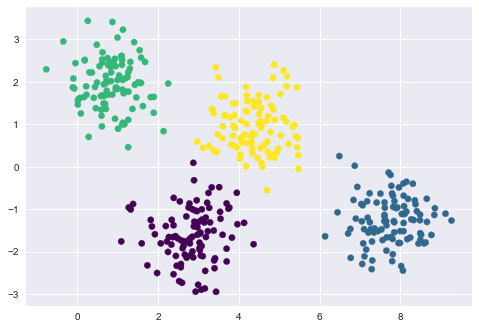

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap = 'viridis')

k-means 中的聚类，其实可以看做是以各个簇为中心画了一个圆,kmeans没有办法形成椭圆形的簇，因为没有权重方面的考虑    
两圆相交的部分，在不同的初始点的kmeans中是可能被分到不同簇的，这就导致结果的不确定性

In [8]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_cluster=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    # 画出输入数据
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    
    # 画出k-means模型的表示
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels==i], [center]).max() for i,center in enumerate(centers)]
    for c,r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r,fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        

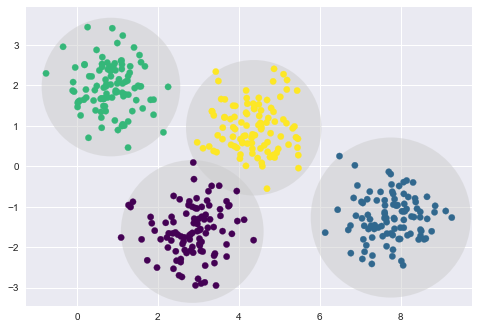

In [9]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

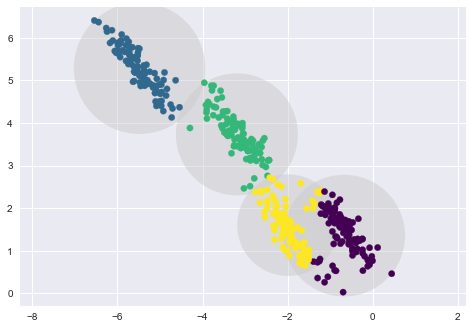

In [10]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

可以看到当数据簇有重合的时候，数据判断就会有误，这里黄色和紫色就无法准确的判断（切面还是线性的）

## 一般化 EM：高斯混合模型

一个高斯混合模型，试图找到多维高斯概率分布的混合体，从而获得任意数据集最好的模型。在最简单的场景中，GMM可以用于 k-means 相同的方式寻找类

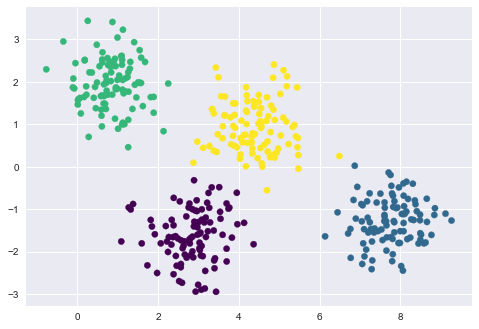

In [12]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:,0], X[:,1], c=labels, s=40, cmap='viridis')

GMM 想象每个类别每个维度的数据都符合一个特定的高斯分布，如此一来，可以对单个点计算属于某个簇的概率，从而确定更属于哪个簇

从效果看，在简单的场景中，kmeans能分类好的数据，GMM也可以，因为GMM其实相当于给每个簇画椭圆

In [13]:
# 某个簇的概率
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[ 0.     0.463  0.     0.537]
 [ 1.     0.     0.     0.   ]
 [ 1.     0.     0.     0.   ]
 [ 0.     0.     0.     1.   ]
 [ 1.     0.     0.     0.   ]]


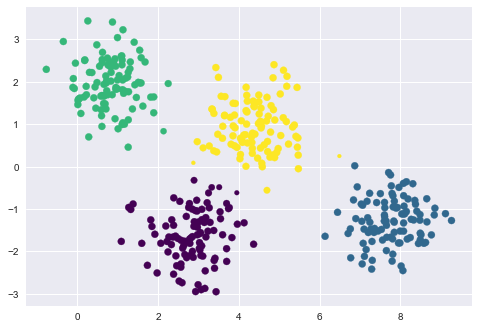

In [14]:
size = 50 * probs.max(1) ** 2  # 平方强调差异
plt.scatter(X[:, 0], X[:, 1], c = labels, cmap = 'viridis', s = size)